In [6]:
import numpy as np
import pandas as pd

In [1]:
import os
from CLEAN.infer import *
# pre-compute esm-1b embedding for sequences in new-392 dataset

os.chdir('/disk1/jyang4/repos/CLEAN/app')
ensure_dirs("data/esm_data")
ensure_dirs("data/pretrained")

## CLEAN

In [2]:
dataset = 'price_test_108'
test = pd.read_csv('/disk1/jyang4/repos/ProteinDT_submission/data/PECT/test_sets/{}.csv'.format(dataset))
df = test.rename(columns={'id': 'Entry', 'brenda': 'EC number', 'sequence': 'Sequence'})
df.drop_duplicates(subset='Entry', inplace=True) #for now drop duplicates to make things easier
df = df[['Entry', 'EC number', 'Sequence']]
df.to_csv('data/{}.csv'.format(dataset), index=False, sep='\t')

csv_to_fasta("data/{}.csv".format(dataset), "data/{}.fasta".format(dataset))
retrive_esm1b_embedding(dataset)

Transferred model to GPU
Read data/price_test_108.fasta with 108 sequences
Processing 1 of 11 batches (14 sequences)
Processing 2 of 11 batches (13 sequences)
Processing 3 of 11 batches (12 sequences)
Processing 4 of 11 batches (11 sequences)
Processing 5 of 11 batches (10 sequences)
Processing 6 of 11 batches (10 sequences)
Processing 7 of 11 batches (9 sequences)
Processing 8 of 11 batches (9 sequences)
Processing 9 of 11 batches (8 sequences)
Processing 10 of 11 batches (7 sequences)
Processing 11 of 11 batches (5 sequences)


In [16]:
dataset = "price"

In [3]:
from CLEAN.infer import infer_maxsep
train_data = "split100"
test_data = dataset
infer_maxsep(train_data, test_data, report_metrics=True, pretrained=True)

The embedding sizes for train and test: torch.Size([241025, 128]) torch.Size([108, 128])


100%|██████████| 5242/5242 [00:00<00:00, 27272.12it/s]


Calculating eval distance map, between 108 test ids and 5242 train EC cluster centers


108it [00:00, 732.56it/s]


############ EC calling results using maximum separation ############
---------------------------------------------------------------------------
>>> total samples: 108 | total ec: 39 
>>> precision: 0.573 | recall: 0.426| F1: 0.457 | AUC: 0.713 | accuracy: 0.426 
---------------------------------------------------------------------------
############ EC calling results using maximum separation ############
---------------------------------------------------------------------------
>>> total samples: 108 | total ec: 39 
>>> precision: 0.573 | recall: 0.426| F1: 0.457 | AUC: 0.713 
---------------------------------------------------------------------------


## diamond BLASTp

In [31]:
swissprot = pd.read_csv('../../processed_data/protein2EC.csv')
train_indices = np.loadtxt('../../splits/task1/protein2EC_train_indices.txt', dtype=int)
swissprot_train = swissprot.iloc[train_indices]
entries = swissprot_train['Entry'].values
sequences = swissprot_train['Sequence'].values
#save sequences to fasta
with open('data/protein2EC_train.fasta', 'w') as f:
    for entry, sequence in zip(entries, sequences):
        f.write('>{}\n{}\n'.format(entry, sequence))

In [11]:
#turn the reference database into diamond database format
!/disk1/jyang4/repos/BLAST/diamond makedb --in data/protein2EC_train.fasta -d data/protein2EC_train

diamond v2.1.9.163 (C) Max Planck Society for the Advancement of Science, Benjamin Buchfink, University of Tuebingen
Documentation, support and updates available at http://www.diamondsearch.org
Please cite: http://dx.doi.org/10.1038/s41592-021-01101-x Nature Methods (2021)

#CPU threads: 384
Scoring parameters: (Matrix=BLOSUM62 Lambda=0.267 K=0.041 Penalties=11/1)
Database input file: data/protein2EC_train.fasta
Opening the database file...  [0.002s]
Loading sequences...  [0.121s]
Masking sequences...  [0.05s]
Writing sequences...  [0.027s]
Hashing sequences...  [0.012s]
Loading sequences...  [0s]
Writing trailer...  [0.003s]
Closing the input file...  [0s]
Closing the database file...  [0s]

Database sequences  149117
  Database letters  48058658
     Database hash  659f394b996c28f89723ac52d0175e6d
        Total time  0.219000s


In [13]:
df = pd.read_csv('../../splits/task1/price_protein_test.csv')
entries = df['Entry'].values
seqs = df['Sequence'].values

In [23]:
#write seqs to fasta format
with open('data/price_protein_test.fasta', 'w') as f:
    for i, (entry, seq) in enumerate(zip(entries, seqs)):
        f.write('>{}\n{}\n'.format(i, seq))

In [24]:
!/disk1/jyang4/repos/BLAST/diamond blastp -d data/protein2EC_train -q data/price_protein_test.fasta -o output/price_protein_test.blastp -k 1

diamond v2.1.9.163 (C) Max Planck Society for the Advancement of Science, Benjamin Buchfink, University of Tuebingen
Documentation, support and updates available at http://www.diamondsearch.org
Please cite: http://dx.doi.org/10.1038/s41592-021-01101-x Nature Methods (2021)

#CPU threads: 384
Scoring parameters: (Matrix=BLOSUM62 Lambda=0.267 K=0.041 Penalties=11/1)
Temporary directory: output
#Target sequences to report alignments for: 1
Opening the database...  [0.065s]
Database: data/protein2EC_train (type: Diamond database, sequences: 149117, letters: 48058658)
Block size = 2000000000
Opening the input file...  [0s]
Opening the output file...  [0s]
Loading query sequences...  [0s]
Masking queries...  [0.017s]
Algorithm: Double-indexed
Building query histograms...  [0.024s]
Seeking in database...  [0s]
Loading reference sequences...  [0.055s]
Masking reference...  [0.043s]
Initializing temporary storage...  [0s]
Building reference histograms...  [0.036s]
Allocating buffers...  [0.004s

In [25]:
blast_results = pd.read_csv('output/price_protein_test.blastp', sep='\t', header=None)
blast_results

,0,1,2,3,4,5,6,7,8,9,10,11
0,0,F2JVT6,51.4,399,181,4,6,403,3,389,5.460000e-147,424.0
1,1,Q1JUQ0,80.5,293,57,0,1,293,16,308,4.910000e-170,474.0
2,2,B8H1Z0,47.4,249,124,4,31,279,6,247,4.480000e-68,213.0
3,3,P31959,41.4,278,146,5,34,301,15,285,2.430000e-55,190.0
4,4,Q9GKX6,39.2,319,184,4,27,344,26,335,6.060000e-71,226.0
...,...,...,...,...,...,...,...,...,...,...,...,...
118,143,P52042,29.2,373,215,12,89,455,47,376,3.010000e-30,124.0
119,144,Q4KCY6,25.1,370,223,13,88,447,45,370,1.400000e-13,74.3
120,145,Q9I6J2,78.3,448,97,0,5,452,7,454,2.450000e-275,753.0
121,146,P19064,29.6,452,283,11,17,455,12,441,2.850000e-51,181.0


<Axes: >

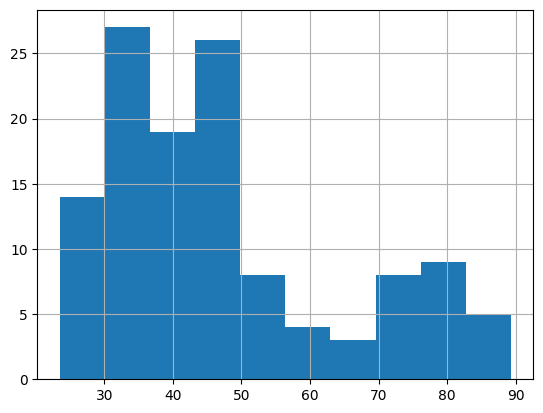

In [26]:
blast_results[2].hist()

Code below needs to be fixed

In [39]:
id2ec = swissprot_train.set_index('Entry')['EC number'].to_dict()

df['index'] = df.index
merged = pd.merge(df, blast_results, left_on='index', right_on=0, how = 'left')
merged

,Entry,EC number,Sequence,index,0,1,2,3,4,5,6,7,8,9,10,11
0,WP_063460136,5.3.1.7,MAIPPYPDFRSAAFLRQHLRATMAFYDPVATDASGGQFHFFLDDGT...,0,0.0,F2JVT6,51.4,399.0,181.0,4.0,6.0,403.0,3.0,389.0,5.460000e-147,424.0
1,WP_063462980,4.2.1.43,VPTTFHEDGTLDLDSQKRCLDFMIDAGVDGVCILANFSEQFSLSDA...,1,1.0,Q1JUQ0,80.5,293.0,57.0,0.0,1.0,293.0,16.0,308.0,4.910000e-170,474.0
2,WP_063462990,1.1.1.48,LIDCNIDMTQLFAPSSSSTDATGAPQGLAKFPSLQGRAVFVTGGGS...,2,2.0,B8H1Z0,47.4,249.0,124.0,4.0,31.0,279.0,6.0,247.0,4.480000e-68,213.0
3,WP_041412631,4.2.1.25,MCLGRRRCHMNNKKPKTLRSASWFGSDDKNGFMYRSWMKNQGIPEH...,3,3.0,P31959,41.4,278.0,146.0,5.0,34.0,301.0,15.0,285.0,2.430000e-55,190.0
4,WP_011717048,5.1.3.3,MQLSVTQKSLQHAAFADELQLVTLTNSHGLEVVLSNYGASIWSVKL...,4,4.0,Q9GKX6,39.2,319.0,184.0,4.0,27.0,344.0,26.0,335.0,6.060000e-71,226.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143,WP_010207013,1.3.8.7,MADYKAPLRDMRFVLNEVFEVATTWAQLPALADTVDAETVEAILEE...,143,143.0,P52042,29.2,373.0,215.0,12.0,89.0,455.0,47.0,376.0,3.010000e-30,124.0
144,WP_010207016,1.3.8.7,MPDYKAPLRDIRFVRDELLGYEAHYQSLPACQDATPDMVDAILEEG...,144,144.0,Q4KCY6,25.1,370.0,223.0,13.0,88.0,447.0,45.0,370.0,1.400000e-13,74.3
145,WP_010207340,2.6.1.19,MSSNNPQTREWQALSSDHHLAPFSDFKQLKEKGPRIITKAHGVYLW...,145,145.0,Q9I6J2,78.3,448.0,97.0,0.0,5.0,452.0,7.0,454.0,2.450000e-275,753.0
146,WP_010207341,6.3.1.11,MSVPPRAVQLNEANAFLKDHPEVLYVDLLIADMNGVVRGKRIERTS...,146,146.0,P19064,29.6,452.0,283.0,11.0,17.0,455.0,12.0,441.0,2.850000e-51,181.0


In [40]:
merged['predicted_ecs'] = merged[1].map(id2ec)
merged.dropna(subset=['predicted_ecs'], inplace=True) #for now drop the ones where the mapping failed

correct = 0
#loop through each row of merged and check if brenda is in predicted_ecs
for index, brenda in zip(merged.index, merged['EC number'].values):
    if brenda in merged.loc[index, 'predicted_ecs']:
        correct += 1
accuracy = correct/len(merged)
print(accuracy)

#accuracy = (merged['brenda'].isin(merged['predicted_ecs'])).mean()
#print(accuracy)

0.3089430894308943
